In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

import pickle, os

In [39]:
def plot_roc_curve(y, prob):
    fpr, tpr, _ = roc_curve(y, prob)
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='example estimator')
    display.plot()

def print_metrics(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_fit = model.predict(X_train)
    y_predict = model.predict(X_test)
    print(f"Train Accuracy: {np.mean(y_train == y_fit)}. Test Accuracy {np.mean(y_test == y_predict)}.")
    plot_roc_curve(y_test, model.predict_proba(X_test)[:,1])

In [5]:
train = pd.read_csv('data/train_8_12.csv', index_col=[0])
X_train = train.drop(["win", "matchId"], axis=1)
y_train = train['win'].astype(int)

test = pd.read_csv('data/test_8_12.csv', index_col=[0])
X_test = test.drop(["win", "matchId"], axis=1)
y_test = test['win'].astype(int)

## Random Forest Classifier

In [22]:
from sklearn.ensemble import RandomForestClassifier

In [37]:
RETRAIN = False
rf_file = "models/rf_cv.pkl"

if os.path.exists(rf_file) and not RETRAIN:
    with open(rf_file, "rb") as f:
        grid = pickle.load(f)
    print("Succesfully loaded cached gridCV result.")
else:
    rf = RandomForestClassifier(random_state=42)
    param_grid = {"n_estimators": (10 ** np.linspace(0, 2.7, 100)).astype(int),
                "max_depth": [6, 8, 10]}
    grid = GridSearchCV(rf, param_grid, scoring="accuracy", n_jobs=-1, verbose=3, cv=10)
    grid.fit(X_train, y_train)

    with open(rf_file, "wb") as f:
        pickle.dump(grid, f)

Succesfully loaded cached gridCV result.


Train Accuracy: 0.8876333961079724. Test Accuracy 0.7070063694267515.


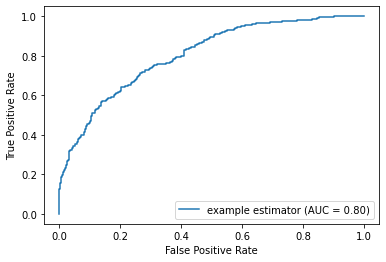

In [40]:
rf_cv_result = pd.DataFrame(grid.cv_results_)
final_rf = grid.best_estimator_

#sns.lineplot(x="param_n_estimators", y="mean_test_score", hue="param_max_depth", data=rf_cv_result)
print_metrics(final_rf, X_train, X_test, y_train, y_test)

In [18]:
grid.best_score_

0.7269572760789418

## XGBoost Classifier

In [6]:
from xgboost import XGBClassifier

In [25]:
RETRAIN = False
xgb_file = "models/xgb_cv.pkl"

if os.path.exists(xgb_file) and not RETRAIN:
    with open(xgb_file, "rb") as f:
        grid = pickle.load(f)
    print("Succesfully loaded cached gridCV result.")

else:
    xgb = XGBClassifier(eval_metric="logloss", use_label_encoder=False, verbosity=0, silent=True, random_state=42)
    param_grid = {"n_estimators": (10**np.linspace(1, 2.3, 10)).astype(int),
                  "subsample": [0.6, 0.8],
                  "colsample_bytree": [0.2, 0.4, 0.6, 0.8],
                  "colsample_bylevel": [0.2, 0.4, 0.6, 0.8],
                  "min_child_weight" : [1, 5, 10],
                  "max_depth": [2, 5, 10],}
    grid = GridSearchCV(xgb, param_grid, scoring="accuracy", verbose=3, cv=5, n_jobs=5)
    grid.fit(X_train, y_train)

    with open(xgb_file, "wb") as f:
            pickle.dump(grid, f)

Succesfully loaded cached gridCV result.


In [31]:
xgb_cv_result = pd.DataFrame(grid.cv_results_)
final_xgb = grid.best_estimator_

print_metrics(final_xgb, X_train, X_test, y_train, y_test)

{'colsample_bylevel': 0.8,
 'colsample_bytree': 0.6,
 'max_depth': 2,
 'min_child_weight': 1,
 'n_estimator': 10,
 'subsample': 0.6}

## HyperOpt

In [11]:
import hyperopt
from hyperopt import hp
from hyperopt.pyll.base import scope
from hyperopt.pyll.stochastic import sample

In [12]:
def objectives(params):
    classifier_type = params['type']
    del params['type']
    if classifier_type == 'rf':
        clf = RandomForestClassifier(**params, random_state=42)
    elif classifier_type == 'xgb':
        clf = XGBClassifier(**params, eval_metric="logloss", use_label_encoder=False, random_state=42)
    accuracy = cross_val_score(clf, X_train, y_train, cv=5, n_jobs=-1).mean()
    return {'loss': -accuracy, 'status': hyperopt.STATUS_OK}

space = hp.choice('clf_type', [
    {
        "type": "rf",
        "n_estimators": sample(scope.int(hp.quniform("n_estimators", 0, 800, 1))),
        "max_depth": sample(scope.int(hp.quniform("max_depth", 5, 15, 1)))
    },
    {
        "type": "xgb",
        "n_estimators": sample(scope.int(hp.quniform("n_estimators", 0, 800, 1))),
        "max_depth": sample(scope.int(hp.quniform("max_depth", 5, 15, 1)))
    }
])

trials = hyperopt.Trials()

best = hyperopt.fmin(objectives, 
                     space, 
                     algo=hyperopt.tpe.suggest, 
                     max_evals=50,
                     trials=trials)

100%|██████████| 50/50 [07:52<00:00,  9.45s/trial, best loss: -0.7187890617298555]


In [13]:
hyperopt.space_eval(space, best)

{'max_depth': 6, 'n_estimators': 437, 'type': 'rf'}